# RC Halo Size

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [3]:
sys.path.append("..") 
from rcgfd import RCDataset, BigPlot, plot_ke_relerr, MetricsPlot, SingleTimePlot

In [4]:
plt.style.use("./rc-gfd.mplstyle")

In [5]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [42]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        {"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        {"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        #{"nrmse": 1, "spectral": 1.0},
    ]
)
ds0 = rcd()
ds0 = ds0.expand_dims({"n_overlap": [1]})

In [43]:
dslist = []
for n_overlap in [4]:
    kw = {"n_reservoir": 12_000} if n_overlap==4 else {} 
    rcd = RCDataset(
        n_sub=[16],
        cost_terms = [
            {"nrmse": 1},
            #{"nrmse": 1, "spectral":1e-3},
            {"nrmse": 1, "spectral":1e-2},
            {"nrmse": 1, "spectral":1e-1},
        ],
        n_overlap=n_overlap,
        **kw
    )
    # Just remember that 4 overlap has larger reservoir
    dslist.append(rcd())
ds = xr.concat(dslist, dim="n_overlap")

In [44]:
ds0 = ds0.drop("n_reservoir")

In [45]:
ds = ds.drop("n_reservoir")

In [48]:
ds = ds.expand_dims({"n_sub": [16]})
ds = xr.concat([ds0,ds], dim="n_overlap")

In [49]:
ds["truth"] = ds["truth"].isel(n_overlap=0, n_sub=0)

In [50]:
ds["gamma"] = xr.DataArray([0., 1e-2, 1e-1], coords=ds.experiment.coords, dims=ds.experiment.dims)
ds = ds.swap_dims({"experiment":"gamma"})

In [51]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

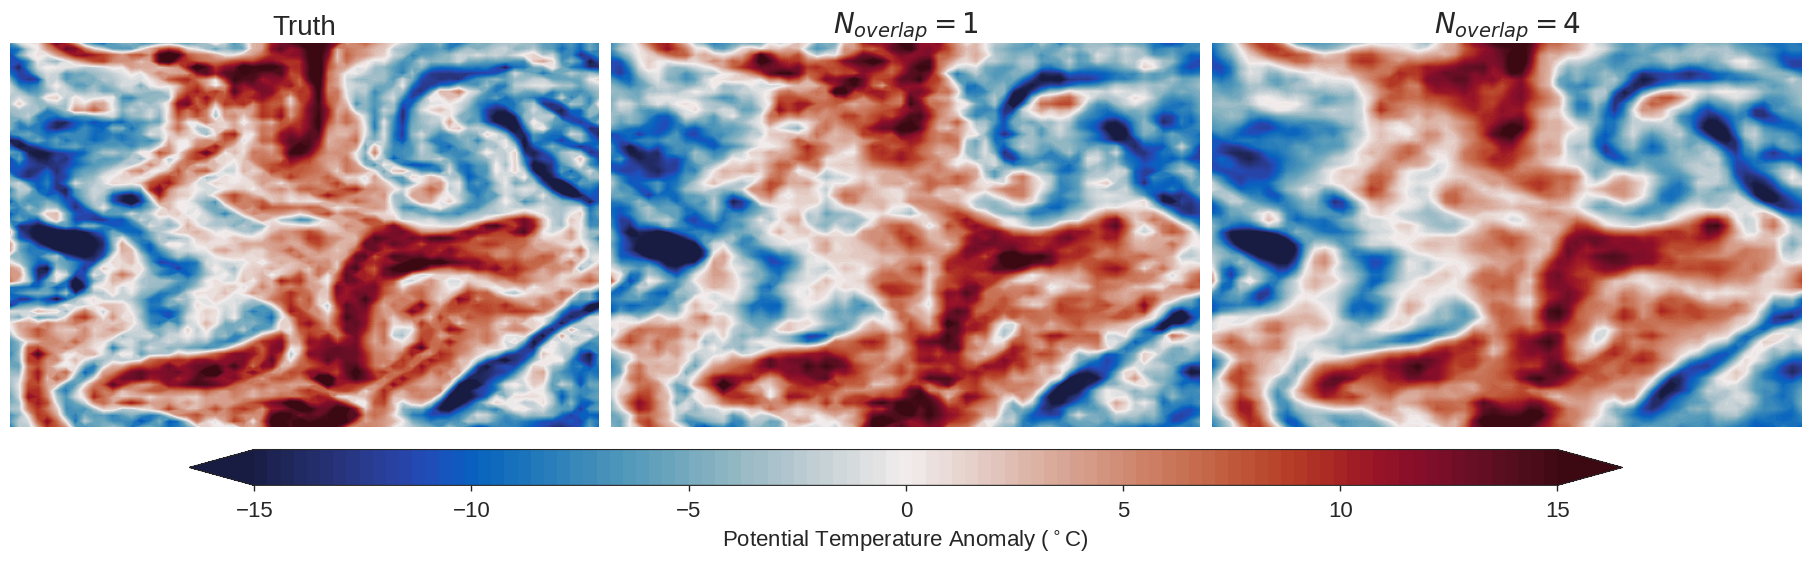

In [52]:
fig, axs = stp(ds.sel(gamma=0.1, n_sub=16, sample=49), col_dim="n_overlap")
[ax.set(title=r"$N_{overlap} = %d$" % n_overlap) for n_overlap, ax in zip(ds.n_overlap.values, axs[1:])];

## Metrics

In [53]:
ds['nrmse'].load();

In [54]:
ds["ke_relnrmse"] = np.sqrt( (ds["ke_rel_err"]**2).mean("k1d") )

In [57]:
class QuickMetricsPlot(MetricsPlot):
    @property
    def color_start(self):
        return 3

In [58]:
mp = QuickMetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="n_sub",
)

### $N_{sub}=16$

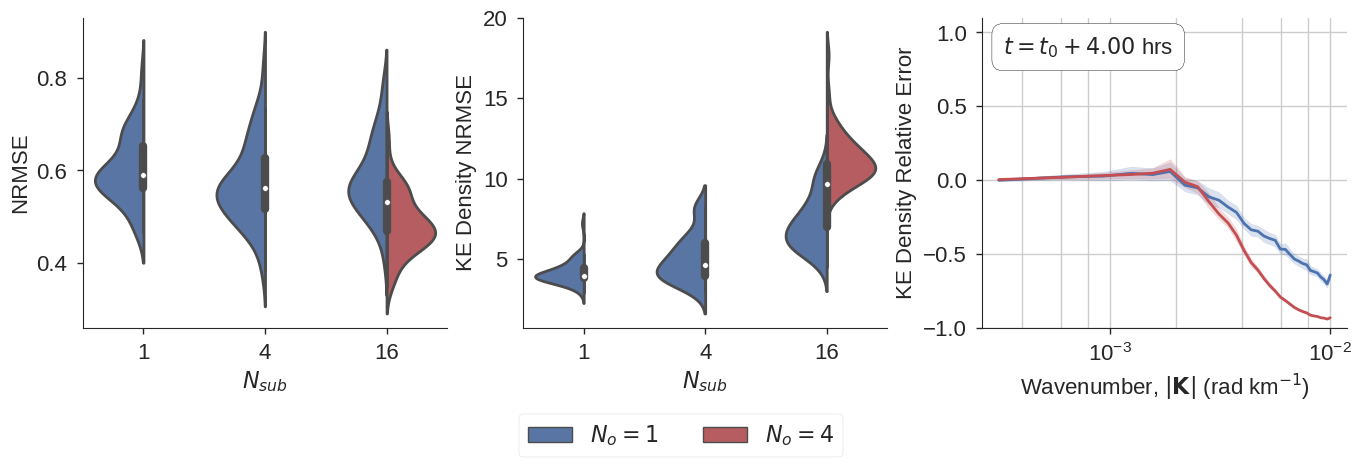

In [70]:
fig, axs = mp(ds.sel(gamma=0.1), show_time=False, hue="n_overlap", split=True)
[ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
[ax.legend().remove() for ax in axs]
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(gamma=0.1, n_sub=16),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_overlap",
    clabel=lambda n_o : r"$N_{o} = %d$" % (n_o),
)
labels = (r"$N_o = 1$",) +  tuple("_nolegend_" for _ in range(4)) + (r"$N_o=4$",)
fig.legend(labels,
           loc="center", bbox_to_anchor=(.5, -.075), ncol=2, frameon=True)

#fig.savefig(f"{fig_dir}/rc_overlap.pdf", bbox_inches="tight")